In [1]:
import json
import os
from collections import defaultdict
import numpy as np
from torch.utils.data import Dataset
import torch



class FEMNIST(Dataset):
    """
    This dataset is derived from the Leaf repository
    (https://github.com/TalwalkarLab/leaf) pre-processing of the Extended MNIST
    dataset, grouping examples by writer. Details about Leaf were published in
    "LEAF: A Benchmark for Federated Settings" https://arxiv.org/abs/1812.01097.
    """

    def __init__(self, train=True, transform=None, target_transform=None, ):
        super(FEMNIST, self).__init__()
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

        train_clients, train_groups, train_data_temp, test_data_temp = read_data("./data/femnist/train",
                                                                                 "./data/femnist/test")
        if self.train:
            self.dic_users = {}
            train_data_x = []
            train_data_y = []
            for i in range(len(train_clients)):
                if i == 100:
                    break
                self.dic_users[i] = set()
                l = len(train_data_x)
                cur_x = train_data_temp[train_clients[i]]['x']
                cur_y = train_data_temp[train_clients[i]]['y']
                for j in range(len(cur_x)):
                    self.dic_users[i].add(j + l)
                    train_data_x.append(np.array(cur_x[j]).reshape(28, 28))
                    train_data_y.append(cur_y[j])
            self.data = train_data_x
            self.label = train_data_y
        else:
            test_data_x = []
            test_data_y = []
            for i in range(len(train_clients)):
                cur_x = test_data_temp[train_clients[i]]['x']
                cur_y = test_data_temp[train_clients[i]]['y']
                for j in range(len(cur_x)):
                    test_data_x.append(np.array(cur_x[j]).reshape(28, 28))
                    test_data_y.append(cur_y[j])
            self.data = test_data_x
            self.label = test_data_y

    def __getitem__(self, index):
        img, target = self.data[index], self.label[index]
        img = np.array([img])
        # img = Image.fromarray(img, mode='L')
        # if self.transform is not None:
        #     img = self.transform(img)
        # if self.target_transform is not None:
        #     target = self.target_transform(target)
        return torch.from_numpy((0.5-img)/0.5).float(), target

    def __len__(self):
        return len(self.data)

    def get_client_dic(self):
        if self.train:
            return self.dic_users
        else:
            exit("The test dataset do not have dic_users!")
def batch_data(data, batch_size, seed):
    '''
    data is a dict := {'x': [numpy array], 'y': [numpy array]} (on one client)
    returns x, y, which are both numpy array of length: batch_size
    '''
    data_x = data['x']
    data_y = data['y']

    # randomly shuffle data
    np.random.seed(seed)
    rng_state = np.random.get_state()
    np.random.shuffle(data_x)
    np.random.set_state(rng_state)
    np.random.shuffle(data_y)

    # loop through mini-batches
    for i in range(0, len(data_x), batch_size):
        batched_x = data_x[i:i + batch_size]
        batched_y = data_y[i:i + batch_size]
        yield (batched_x, batched_y)


def read_dir(data_dir):
    clients = []
    groups = []
    data = defaultdict(lambda: None)

    files = os.listdir(data_dir)
    files = [f for f in files if f.endswith('.json')]
    for f in files:
        file_path = os.path.join(data_dir, f)
        with open(file_path, 'r') as inf:
            cdata = json.load(inf)
        clients.extend(cdata['users'])
        if 'hierarchies' in cdata:
            groups.extend(cdata['hierarchies'])
        data.update(cdata['user_data'])

    clients = list(sorted(data.keys()))
    return clients, groups, data



def read_data(train_data_dir, test_data_dir):
    '''parses data in given train and test data directories

    assumes:
    - the data in the input directories are .json files with
        keys 'users' and 'user_data'
    - the set of train set users is the same as the set of test set users

    Return:
        clients: list of client ids
        groups: list of group ids; empty list if none found
        train_data: dictionary of train data
        test_data: dictionary of test data
    '''
    train_clients, train_groups, train_data = read_dir(train_data_dir)
    test_clients, test_groups, test_data = read_dir(test_data_dir)

    assert train_clients == test_clients
    assert train_groups == test_groups

    return train_clients, train_groups, train_data, test_data



In [2]:
import matplotlib
import argparse
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch
import torch.nn as nn # import modules

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models_v2.Update import LocalUpdate
from models_v2.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, MobileNetV2, LeNet5, LeNet10
from models_v2.Fed import FedAvg
from models_v2.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models_v2.test import test_img

%load_ext autoreload
%autoreload 2
from torch.autograd import grad
parser = argparse.ArgumentParser(description='Deep Leakage from Gradients.')
parser.add_argument('--index', type=int, default="25",
                    help='the index for leaking images on CIFAR.')
parser.add_argument('--image', type=str,default="",
                    help='the path to customized image.')
args = parser.parse_args([])
from torch.autograd import grad

In [3]:
class my_argument:    
    epochs = 400    #"rounds of training"
    num_users = 100  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep=1 #"the number of local epochs: E"
    local_bs=10 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.001 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    weight_decay = 5e-4
    opt = 'ADAM'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='femnist' #, help="name of dataset")
    iid=0
    num_classes=62#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    model='mlp'
    q=20
    f_size=32
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cpu")
args.device = torch.device("cuda:0" if use_cuda else "cpu")
print(args.device)

True
cuda:0


In [4]:
print(args.opt)

ADAM


In [5]:
from models_v2.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient, weight_vectorization_gen2


In [6]:
def phiQ(p,sc, q, w):
    w_cap = w #[:,0]
    #w_cap=[item[0] if isinstance(item,list) and len(item)>0 else item for item in w_cap]
    #w_cap=np.array(w_cap)
    #print("w_cap_first")
    #print(w_cap)
    w_cap= sc*w_cap
    v=np.floor(q*w_cap)
    one=np.ones(len(w))
    r=np.random.uniform(0,1,len(w_cap))
    temp=(one.T+np.sign(q*w_cap-v-r))*np.sign(q*w_cap-v-r)
    #j=np.sign(w_cap-v-r)
    #print("jjj")
    #print(j)
    #temp= (1/q)*(1/2)*temp
    temp=(1/2)*temp
    #print("temp")
    #print(temp)
    #w_cap= (1/q)*v + temp
    w_cap=(1/q)*(v+temp)
    w_cap=q*w_cap
    #w_cap=w_cap+ (1/2)*p*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    w_cap=w_cap+ (1/2)*(p-5)*(-np.sign(w_cap)+one.T)*(-np.sign(w_cap))
    #print("w_cap_last")
    #print(w_cap)
    del temp
    del one
    del v
    del r
    return w_cap
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('/data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('/data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
        print('iid dataset')
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
        print("non iid dataset")
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
elif args.dataset == 'femnist':
    dataset_train = FEMNIST(train=True)
    dataset_test = FEMNIST(train=False)
    dict_users = dataset_train.get_client_dic()
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape


In [7]:
def toNumpyFlatArray(self):
        return self.flat


def updateFromNumpyFlatArray(self, arr):
    self.flat = arr
    start = 0
    new_glob = OrderedDict()
    for k in self.w_glob.keys():
        size = 1
        for dim in self.w_glob[k].shape:
            size *= dim
        shaped = np.reshape(arr[start : start + size].copy(), self.w_glob[k].shape)
        new_glob[k] = torch.from_numpy(shaped)
        start = start + size
    self.w_glob = new_glob
    self.net_glob.load_state_dict(self.w_glob)

In [8]:
beta=[1,1/2,1/4,1/8,1/16]
#beta=[1,1,1,1,1]
beta=[1,1,1/2,1/2,1/4]
#beta=[1,1/2,1/4,1/8]
beta=[1,1/2,1/4]
comp=[]
i=0
for j in range(args.num_users):
    comp.append(beta[i])
    if (j>0 and j%33==0):
        i+=1


In [9]:
print(comp)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]


In [ ]:
#print(dict_users[2])

In [ ]:
#print(dict_users[10])

In [ ]:
print(len(dict_users[2]))

# 1. FedAvg with A=0

In [10]:

local_lr = 1e-4
local_steps = 1
use_updates = True

In [11]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        nn.init.xavier_uniform(m.weight.data, nn.init.calculate_gain('relu'))
        #nn.init.xavier_uniform(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, torch.nn.Linear):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.BatchNorm2d):
        seed=123
        torch.cuda.manual_seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        #conv1.bias.data.fill_(0.01)

In [12]:
from models_v2.Fed import FedAdd,FedSubstract,weight_vectorization_gen,FedAvg_gradient
import numpy as np
import copy
import random
# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == "mobilenetv2":
    net_glob = MobileNetV2(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    print(len_in)
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.apply(weights_init)
net_glob.train()

784
MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=62, bias=True)
)


MLP(
  (layer_input): Linear(in_features=784, out_features=200, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (layer_hidden): Linear(in_features=200, out_features=62, bias=True)
)

In [ ]:
#print(w_glob['layer_hidden.weight'][:,s:s+y])

In [13]:
s_1=[]
for i in range(args.num_users):
    s_1.append(np.random.randint(200))

In [14]:
def update_local_model( w_hold,w_local, y,s):
    if (s+y>200):
            w_glob_hold['layer_input.weight'][0:y-(200-s),:]=w_local['layer_input.weight'][0:y-(200-s),:]
            w_glob_hold['layer_input.weight'][s:200,:]=w_local['layer_input.weight'][-(200-s):,:]
            #combined=torch.concatenate((first,middle),axis=0)
    
    else:
            w_glob_hold['layer_input.weight'][s:s+y,:]= w_local['layer_input.weight']
            #combined=middle
    #w_glob['layer_input.weight']=combined
    if (s+y>200):
            w_glob_hold['layer_input.bias'][0:y-(200-s)]=w_local['layer_input.bias'][0:y-(200-s)]
            w_glob_hold['layer_input.bias'][s:200]=w_local['layer_input.bias'][-(200-s):]
            #combined=torch.concatenate((first,middle),axis=0)
    
    else:
            w_glob_hold['layer_input.bias'][s:s+y] = w_local['layer_input.bias']
           
    #w_glob['layer_input.bias']=combined
        
    if (s+y>200):
            w_glob_hold['layer_hidden.weight'][:,0:y-(200-s)]=w_local['layer_hidden.weight'][:,0:y-(200-s)]
            w_glob_hold['layer_hidden.weight'][:,s:200]=w_local['layer_hidden.weight'][:,-(200-s):]
            #combined=torch.concatenate((first,middle),axis=1)
    else:
            w_glob_hold['layer_hidden.weight'][:,s:s+y]=w_local['layer_hidden.weight']
    w_glob_hold['layer_hidden.bias']=w_local['layer_hidden.bias']
            #combined=middle
    #w_glob['layer_hidden.weight']=combined
    return w_glob_hold

In [15]:
print(s_1)

[109, 126, 66, 98, 17, 83, 106, 123, 57, 96, 113, 126, 47, 73, 32, 174, 111, 153, 83, 78, 164, 96, 68, 49, 55, 195, 2, 84, 39, 66, 84, 47, 189, 176, 135, 105, 99, 124, 92, 180, 102, 97, 118, 94, 155, 34, 76, 168, 131, 106, 69, 64, 75, 162, 58, 138, 22, 146, 15, 155, 158, 180, 70, 109, 115, 154, 134, 14, 103, 182, 199, 129, 43, 186, 101, 183, 25, 178, 56, 49, 12, 18, 1, 51, 172, 117, 48, 56, 177, 86, 3, 67, 139, 149, 103, 98, 3, 139, 3, 6]


In [16]:
from models_v2.Fed import FedAdd,FedSubstract,weight_vectorization_cifar,FedAvg_gradient, weight_vectorization_gen, weight_vectorization_gen2
#net_glob = LeNet10().to(args.device)
#net_glob.train()
args.lr=0.00025
import torchvision.models as models
dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
net_glob.apply(weights_init)
w_glob=torch.load("linear_FEMNIST.pt")
net_glob.load_state_dict(w_glob)
net_glob.train()
#net_glob.load_state_dict(w_glob)
net_glob=net_glob.to(dev)
net_glob.train()
# copy weights
#net_glob=torch.hub.load('pytorch/vision:v0.10.0','resnet18',pretrained=False)
#net_glob.eval()
w_glob = net_glob.state_dict()
g, dim = weight_vectorization_gen(w_glob)

w_glob=net_glob.state_dict()
# print(w_glob)
# print(w_glob.keys())
for k in w_glob.keys():
    print(w_glob[k].shape)
net_glob_original=copy.deepcopy(net_glob)
net_glob_original.to(dev)
w_glob_original=copy.deepcopy(w_glob)
w_glob_hold=net_glob_original.state_dict()
#print(w_glob_hold)
for h in w_glob_hold.keys():
    print(w_glob_hold[h].shape)
    #print(w_glob[h])
    w_glob_hold[h]=torch.zeros(w_glob_hold[h].shape)
    print(type(w_glob[h]))

torch.Size([200, 784])
torch.Size([200])
torch.Size([62, 200])
torch.Size([62])
torch.Size([200, 784])
<class 'torch.Tensor'>
torch.Size([200])
<class 'torch.Tensor'>
torch.Size([62, 200])
<class 'torch.Tensor'>
torch.Size([62])
<class 'torch.Tensor'>


In [ ]:
print(w_glob_original)

In [17]:

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

m_local=[]
d=11699132 #resnet18
d= 11173962
d=11183582
d=21840
#d= 11699132
#d=62006
iter_no=2000
avg=[]
error=[]
idxs_users=range(0,args.num_users)
    #print(len(idxs_users))
user_no=args.num_users
updated=[]
a=[]
for user in idxs_users:
        #print(user)
    updated.append([])  
    a.append([])   
model_diff=[]




#net_glob.zero_grad()
input_gradient=[]

user_no=args.num_users

select=round(0.9*user_no)

K_local=round(1*d)
loss_train=[]    
#net_glob.zero_grad()   
for iter in range(iter_no): #args.epochs
    print("iteration no.",iter)
#     if (iter>=10):
#         args.lr=0.0001
    if (iter>=500):
        args.lr=args.lr #/5
    m_local=[]
    f=[]
        #T=[]
    w_locals, loss_locals,diff_locals,grad_locals = [], [],[],[]
    m = 10
    updated=[]
    model_diff=[]
    grad_vect=[]
    prev=[]
    error=[]
    grad_vect_quant=[]
    grad_vect_quant2=[]
    grad_vect_send=[]
    grad_vect_send2=[]
    store_grad=[]
    location_local=[]
    rand=np.random.choice(idxs_users,user_no,replace=False)
    rand=idxs_users
    np.random.seed(iter)
    rand=np.random.choice(idxs_users, select, replace=False)
    rand=np.sort(rand)
    loss_train_user=[]
    for i in range(args.num_users):
        updated.append([])
        model_diff.append([])
        grad_vect.append([])
        prev.append([])
        grad_vect_send.append([])
        error.append(np.zeros(d))
        grad_vect_quant.append([])
    
    
    for user in rand : #rand: #idxs_users:
        #print(user)
        
        w_glob = net_glob_original.state_dict()
        
        s_1[user]=s_1[user]%200
        s=s_1[user]
#print(w_glob['layer_input.weight'][:,s:s+10])
        

        y=int(comp[user]*200)

        if (s+y>200):
            first=w_glob['layer_input.weight'][0:y-(200-s),:]
            #print(first.shape)
            middle=w_glob['layer_input.weight'][s:200,:]
            #print(middle.shape)
            combined=torch.concatenate((first,middle),axis=0)
            #print(combined.shape)
    
        else:
            middle=w_glob['layer_input.weight'][s:s+y,:]
            combined=middle
        w_glob['layer_input.weight']=combined
        if (s+y>200):
            first=w_glob['layer_input.bias'][0:y-(200-s)]
            middle=w_glob['layer_input.bias'][s:200]
            combined=torch.concatenate((first,middle),axis=0)
    
        else:
            middle=w_glob['layer_input.bias'][s:s+y]
            combined=middle
        w_glob['layer_input.bias']=combined
        
        if (s+y>200):
            first=w_glob['layer_hidden.weight'][:,0:y-(200-s)]
            middle=w_glob['layer_hidden.weight'][:,s:200]
            combined=torch.concatenate((first,middle),axis=1)
        else:
            middle=w_glob['layer_hidden.weight'][:,s:s+y]
            combined=middle
        w_glob['layer_hidden.weight']=combined
        
        #print(w_glob)
        
        net_glob = MLP(dim_in=len_in, dim_hidden=y, dim_out=args.num_classes).to(args.device)
        net_glob.train()
        net_glob.to(dev)
        
        net_glob.load_state_dict(w_glob)
        s_1[user]=(s_1[user]+1)%200
        
        prev[user]=copy.deepcopy(w_glob)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[user])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         input_gradient=inversefed.reconstruction_algorithms.loss_steps(net_glob, ground_truth[user], labels[user], 
#                                                         lr=local_lr, local_steps=local_steps,
#                                                                    use_updates=use_updates)
        
        loss_train_user.append(loss)
    
        model_diff=FedSubstract(w,prev[user])
        #print(model_diff)
        
        g, dim = weight_vectorization_gen(model_diff)
        print(len(g))
        
        model_diff=update_local_model(w_glob_hold, model_diff, y,s)
        #print(model_diff2)
        
        g, dim = weight_vectorization_gen(model_diff)
        #print(len(g))
        g=g[:,0] #+error[user]
        grad1=abs(np.array(g))
        #location_local=np.random.choice(range(d),K_local,replace=False)
        #location_local=np.argpartition(grad1,-K_local)[-K_local:]
        #a[user].append(np.sort(location_local))
        #if iter>0:
            #print(len(set(a[user][iter-1]).intersection(set(a[user][iter]))))
        #print(a)
#         mask=np.zeros(d)
#         np.put(mask,location_local,1)
        grad_vect[user]= g #np.multiply(g,mask)
        scale=1/(1*0.9*args.num_users)
        grad_vect_quant[user]= scale*grad_vect[user] #phiQ(np.power(2,args.f_size),scale,2**args.q,grad_vect[user])
        #error[user]=g-grad_vect[user]
        grad_locals.append(grad_vect_quant[user])
        del g
        print(user)
    grad_avg=sum(grad_locals) #/len(grad_locals)
    loss_train.append(sum(loss_train_user)/len(loss_train_user))
    grad_avg=sum(grad_locals) # taking the average of masked gradients
    #grad_avg2=np.nan_to_num(sum(grad_locals2))
    #print("grad_avg")
    #print(grad_avg)
    grad_avg_correct = grad_avg #np.zeros_like(grad_avg)
    #print("before modulo")
    #print(grad_avg)
    #grad_avg= (grad_avg)%(np.power(2,args.f_size)-5)
    #print("after modulo")
    #print(grad_avg)
    p=np.power(2,args.f_size)-5
#     for i in range(len(grad_avg)):
#         if grad_avg[i]>=0 and grad_avg[i]<(p-1)/2:
#                         # print("Valid")
#             grad_avg_correct[i]=grad_avg[i]
#             grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
#             #grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
#             continue
#         elif grad_avg[i]>=(p-1)/2 and grad_avg[i]<p:
#                         # print("Chenged")
#             grad_avg_correct[i]=grad_avg[i]-p
#             grad_avg_correct[i]=(1/(2**args.q))*grad_avg_correct[i]
    count=0
    w_glob_prev=copy.deepcopy(w_glob_original)
    flat=[]
    #conver
    for i in range(len(w_glob.keys())): # 4 layers in parameter
        flat.append([])

    for h in w_glob_prev.keys():
        s=list(w_glob_original[h].shape)
        if (len(s)==0):
            new=np.array(0)
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0])
        else:
            z=np.prod(list(w_glob_original[h].shape))
            flat[count]=grad_avg_correct[0:z] # taking out the vector for the specified layer
            grad_avg_correct=np.delete(grad_avg_correct,np.s_[0:z]) # deleting that vector from decoded after taking out
             
            new=flat[count].reshape(list(w_glob_original[h].shape)) #reshaping back to the marix
              
        w_glob_original[h]=torch.from_numpy(new) #converting the matrix to a tensor
            #print(w_glob[cluster_no][h].shape)
        count=count+1
    global_diff = w_glob_original
    #print(w_glob)
    w_glob_original=FedAdd(w_glob_prev,global_diff)
    # update global weights
    #global_diff = w_glob
    #print(w_glob)
    #w_glob=FedAdd(w_glob_prev,global_diff)
    

    # copy weight to net_glob
    net_glob_original.load_state_dict(w_glob_original)
    
    del w_glob_prev
    del grad_locals
    del grad_avg
    del flat
    torch.cuda.empty_cache()

    # print loss
    #loss_avg = np.nan_to_num(sum(loss_locals) / len(loss_locals))
    
    #loss_train.append(float(loss_avg))
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(float(acc_test))
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        #print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
 
        print("accuracy array")
        print(acc_test_arr[iter])
        print("train loss")
        print(loss_train[iter])       
        
        
   
       



iteration no. 0
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
0.311750590801239
train loss
4.320435811243297
iteration no. 1
169462
0
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
55
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
11.390887260437012
train loss
3.8698956444486656
iteration no. 10
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
11.966426849365234
train loss
3.6864806660407616
iteration no. 19
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
17.649879455566406
train loss
3.5659197736419728
iteration no. 28
169462
0
169462
2
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169

169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
19.97601890563965
train loss
3.46670345936461
iteration no. 37
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
16946

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
26.25899314880371
train loss
3.353105843033291
iteration no. 46
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462

169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
27.577938079833984
train loss
3.283224840378622
iteration no. 55
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169

169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
32.06235122680664
train loss
3.172758697119418
iteration no. 64
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169

169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
30.863309860229492
train loss
3.099576333225359
iteration no. 73
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
16

169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
accuracy array
34.58033752441406
train loss
3.043973400056607
iteration no. 82
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16


169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
36.426856994628906
train loss
3.0014020610831764
iteration no. 91
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18

169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
38.08153533935547
train loss
2.892826765072209
iteration no. 100
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462

169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
40.095924377441406
train loss
2.885938357655948
iteration no. 109
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
16
169462
17
169462
18
169462
19
169462


169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
40.719425201416016
train loss
2.7749404598934464
iteration no. 118
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462


169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
75
42412
76
42412
78
42412
79
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
39.61630630493164
train loss
2.7407606214812
iteration no. 127
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
1

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
40.07194137573242
train loss
2.7165773063088148
iteration no. 136
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
16

169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
82
42412
83
42412
84
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
41.199039459228516
train loss
2.6284766034746125
iteration no. 145
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462

169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
42.110313415527344
train loss
2.6224962851882885
iteration no. 154
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
42.75779342651367
train loss
2.6012954315610455
iteration no. 163
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
40.76738739013672
train loss
2.6093669100602286
iteration no. 172
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
40.40767288208008
train loss
2.5429177732870034
iteration no. 181
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
41.03117370605469
train loss
2.5513047658146855
iteration no. 190
169462
0
169462
1
169462
2
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
16

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
41.31894302368164
train loss
2.5116268474116725
iteration no. 199
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
43.09352493286133
train loss
2.524522430482984
iteration no. 208
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
43.021583557128906
train loss
2.471663527393367
iteration no. 217
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
1694

169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
45.131893157958984
train loss
2.445969717320744
iteration no. 226
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462

169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
46.28297424316406
train loss
2.4455965327972384
iteration no. 235
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
48.08153533935547
train loss
2.3994990838690535
iteration no. 244
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
9
169462
11
16946

169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
46.52278137207031
train loss
2.363750323470724
iteration no. 253
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462


169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
46.354915618896484
train loss
2.3643981167255768
iteration no. 262
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.84892272949219
train loss
2.3946673020391582
iteration no. 271
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
1694

169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
46.5467643737793
train loss
2.365639393467959
iteration no. 280
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
36
84762
37
84762
38
84762
39
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
45.01198959350586
train loss
2.3042979908706793
iteration no. 289
169462
0
169462
1
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
1

169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
46.45083999633789
train loss
2.3666984658656305
iteration no. 298
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
95
42412
98
42412
99
accuracy array
47.410072326660156
train loss
2.308563944345761
iteration no. 307
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
95
42412
96
42412
98
accuracy array
46.52278137207031
train loss
2.2848079922629654
iteration no. 316
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
16

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
45.515586853027344
train loss
2.351290914520329
iteration no. 325
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
46.78657150268555
train loss
2.3068202276091005
iteration no. 334
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.80815505981445
train loss
2.327918846455229
iteration no. 343
169462
0
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462


169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
47.38608932495117
train loss
2.2959786785339706
iteration no. 352
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462


169462
0
169462
1
169462
2
169462
3
169462
4
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
62
84762
63
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.417266845703125
train loss
2.32363634114982
iteration no. 361
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
9
169462
10
16946

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
49.44844055175781
train loss
2.2418247762824484
iteration no. 370
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462


169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.256595611572266
train loss
2.2776647532339305
iteration no. 379
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169

169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.335731506347656
train loss
2.292061610069375
iteration no. 388
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462


169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
47.76978302001953
train loss
2.2868152486776543
iteration no. 397
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462

0
169462
2
169462
3
169462
4
169462
5
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
accuracy array
47.38608932495117
train loss
2.298851293928502
iteration no. 406
169462
0
169462
1
169462
2
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
12
1

0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
46.23501205444336
train loss
2.251875147583595
iteration no. 415
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
1

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
47.69784164428711
train loss
2.237867015710857
iteration no. 424
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462


169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
47.649879455566406
train loss
2.258233773798285
iteration no. 433
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
16

169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
47.50599670410156
train loss
2.23754319283004
iteration no. 442
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.68105697631836
train loss
2.241403154351158
iteration no. 451
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
88
42412
90
42412
91
42412
92
42412
93
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.201438903808594
train loss
2.2223690056409304
iteration no. 460
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
1694

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.62350082397461
train loss
2.2739133125609143
iteration no. 469
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.85611343383789
train loss
2.246582525382313
iteration no. 478
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
15
16

169462
5
169462
6
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.78417205810547
train loss
2.259392749257513
iteration no. 487
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
1694

169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
97
42412
98
42412
99
accuracy array
50.887290954589844
train loss
2.267711777910562
iteration no. 496
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14


169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
42
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.647483825683594
train loss
2.2225664561821263
iteration no. 505
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16


169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.68105697631836
train loss
2.218533657080095
iteration no. 514
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
27
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.39328384399414
train loss
2.2567204742433025
iteration no. 523
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
1

169462
4
169462
5
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.38369369506836
train loss
2.2174800794186873
iteration no. 532
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
15
1

169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.75299835205078
train loss
2.256355906788098
iteration no. 541
169462
0
169462
1
169462
2
169462
4
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18

169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.342926025390625
train loss
2.2168852550836036
iteration no. 550
169462
0
169462
1
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.13669204711914
train loss
2.199957566811808
iteration no. 559
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
16946

169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
51.70263671875
train loss
2.2018976060792377
iteration no. 568
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
13
169462
14
169462
15
169462

169462
3
169462
4
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
49.83213424682617
train loss
2.170255089366398
iteration no. 577
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
1

169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
49.68824768066406
train loss
2.2445841425162603
iteration no. 586
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
52.01438903808594
train loss
2.224695546230597
iteration no. 595
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
33
84762
34
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.68585205078125
train loss
2.177688170831199
iteration no. 604
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169

169462
2
169462
3
169462
4
169462
7
169462
8
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
50.55155944824219
train loss
2.2222366416890655
iteration no. 613
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
1694

2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.93525314331055
train loss
2.1863138957745165
iteration no. 622
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
52
84762
53
84762
55
84762
56
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.51319122314453
train loss
2.2106368036474273
iteration no. 631
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
96
42412
98
accuracy array
48.94484329223633
train loss
2.2061514629998586
iteration no. 640
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16

169462
4
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
48.53717041015625
train loss
2.1576645529597362
iteration no. 649
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
48.36930465698242
train loss
2.1803408986151034
iteration no. 658
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
48.94484329223633
train loss
2.2125139078813447
iteration no. 667
169462
1
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16

169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
49.640289306640625
train loss
2.1735923172108818
iteration no. 676
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12


169462
3
169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
49.92805862426758
train loss
2.175507673092691
iteration no. 685
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.48680877685547
train loss
2.2309030577100106
iteration no. 694
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
76
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.0479621887207
train loss
2.1855497647117494
iteration no. 703
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1694

169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.06235122680664
train loss
2.140790689520627
iteration no. 712
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.7505989074707
train loss
2.203353137941575
iteration no. 721
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.127098083496094
train loss
2.17472004756116
iteration no. 730
169462
0
169462
1
169462
2
169462
3
169462
5
169462
7
169462
8
169462
9
169462
10
169462
13
169462
14
169462
15
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
50.5275764465332
train loss
2.20339762485347
iteration no. 739
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
16946

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.59952163696289
train loss
2.181006045470302
iteration no. 748
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462


169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
98
42412
99
accuracy array
51.29496383666992
train loss
2.1964979047614603
iteration no. 757
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.08872985839844
train loss
2.1616336608978792
iteration no. 766
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
17
169462
18
169462
19
169462
20
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
73
42412
74
42412
75
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.97602081298828
train loss
2.1773725434199482
iteration no. 775
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16946

169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.127098083496094
train loss
2.145201777517252
iteration no. 784
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
13
169462
14
169462
16
16

169462
2
169462
3
169462
4
169462
5
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.589927673339844
train loss
2.1718465629543555
iteration no. 793
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169

169462
3
169462
4
169462
5
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.00719451904297
train loss
2.217775206808077
iteration no. 802
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
1

169462
4
169462
5
169462
6
169462
7
169462
8
169462
11
169462
12
169462
13
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.38369369506836
train loss
2.1377992251263027
iteration no. 811
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
14
1694

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
52.9736213684082
train loss
2.1497488871917927
iteration no. 820
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.08633041381836
train loss
2.2040789297526135
iteration no. 829
169462
0
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
51.966426849365234
train loss
2.1686195078563664
iteration no. 838
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
47.98561096191406
train loss
2.1864728920529752
iteration no. 847
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
4
169462
5
169462
6
169462
7
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.15107727050781
train loss
2.1635906905028333
iteration no. 856
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
16

169462
4
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
49.664268493652344
train loss
2.177525918086987
iteration no. 865
169462
1
169462
2
169462
3
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169

169462
3
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.28776931762695
train loss
2.177920371060757
iteration no. 874
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
48.417266845703125
train loss
2.214543332739989
iteration no. 883
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
23
169462
24
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.112709045410156
train loss
2.1102228142826425
iteration no. 892
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
16946

4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.59952163696289
train loss
2.1841541324483966
iteration no. 901
169462
0
169462
2
169462
3
169462
4
169462
7
169462
8
169462
9
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19

169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
49.520381927490234
train loss
2.1845471643250036
iteration no. 910
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169

169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.07913589477539
train loss
2.149981340870705
iteration no. 919
169462
0
169462
1
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
51.53477096557617
train loss
2.18333464696232
iteration no. 928
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462


169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
42412
67
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.51798629760742
train loss
2.1495957701781996
iteration no. 937
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
16946

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
84762
34
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.647483825683594
train loss
2.138954115644606
iteration no. 946
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462

169462
4
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.67865753173828
train loss
2.1605160296422117
iteration no. 955
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
90
42412
91
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.27817916870117
train loss
2.169380177251987
iteration no. 964
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
1

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
50.83932876586914
train loss
2.1377580907804634
iteration no. 973
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
3
169462
4
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
50.81534957885742
train loss
2.1286831269676805
iteration no. 982
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
48.48920822143555
train loss
2.179758854700812
iteration no. 991
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
1

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
90
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.781776428222656
train loss
2.144148799457587
iteration no. 1000
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.30935287475586
train loss
2.145199490170078
iteration no. 1009
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
1694

169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
93
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
53.30935287475586
train loss
2.122184810071973
iteration no. 1018
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14


169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.60671615600586
train loss
2.1504970835876156
iteration no. 1027
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
1694

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.966426849365234
train loss
2.1522885808852354
iteration no. 1036
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462

169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
53.501197814941406
train loss
2.172224888884985
iteration no. 1045
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.70983123779297
train loss
2.1454074214033243
iteration no. 1054
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.9736213684082
train loss
2.1747489126106605
iteration no. 1063
169462
0
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
58
84762
60
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.21582794189453
train loss
2.187170792722483
iteration no. 1072
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
1694

169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.640289306640625
train loss
2.165174815320837
iteration no. 1081
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
9
169462

169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
78
42412
79
42412
80
42412
81
42412
84
42412
85
42412
86
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
49.40047836303711
train loss
2.1086028288138072
iteration no. 1090
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
64
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.56834411621094
train loss
2.133497312890639
iteration no. 1099
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.19184494018555
train loss
2.157107758983768
iteration no. 1108
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1694

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
37
84762
38
84762
39
84762
40
84762
41
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
49.80815505981445
train loss
2.183876681324195
iteration no. 1117
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12
169

169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
60
84762
61
84762
62
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.55155944824219
train loss
2.1672267869945507
iteration no. 1126
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
12
169462
14
169

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.904075622558594
train loss
2.1776763428227803
iteration no. 1135
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
15
16

169462
4
169462
5
169462
6
169462
7
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
87
42412
88
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
49.40047836303711
train loss
2.1130132124529624
iteration no. 1144
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
1

169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
63
84762
64
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.942447662353516
train loss
2.1736060485915094
iteration no. 1153
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12


169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.00719451904297
train loss
2.1706027078235355
iteration no. 1162
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
16

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.03117370605469
train loss
2.1122883966266928
iteration no. 1171
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
11
169462
12
169462
14
169462
16
169462
17
169462
19
169462
20
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
52
84762
53
84762
54
84762
55
84762
56
84762
58
84762
59
84762
60
84762
62
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.07913589477539
train loss
2.2153674252972797
iteration no. 1180
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
10
169462
11
169462
12
169462
13
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
12
169462
13
169462
14
169462
16
169462
17
169462
18
169462
19
169462
21
169462
22
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.63788986206055
train loss
2.1458866220829718
iteration no. 1189
169462
0
169462
1
169462
2
169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
16946

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
15
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
27
169462
28
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
51.84652328491211
train loss
2.1547225235726595
iteration no. 1198
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
169462
12
169462

169462
3
169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
96
42412
97
42412
98
42412
99
accuracy array
49.256595611572266
train loss
2.118538398399914
iteration no. 1207
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
8
169462
9
169462
10
169462
11
16

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
19
169462
20
169462
21
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
52.038368225097656
train loss
2.111088580498879
iteration no. 1216
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
17
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
52.038368225097656
train loss
2.1334027676689105
iteration no. 1225
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
1694

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
17
169462
18
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
72
42412
73
42412
74
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
51.99040603637695
train loss
2.1553842207588327
iteration no. 1234
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
16946

169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
44
84762
45
84762
46
84762
47
84762
49
84762
50
84762
51
84762
52
84762
53
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.575538635253906
train loss
2.1239473100455943
iteration no. 1243
169462
0
169462
1
169462
2
169462
4
169462
5
169462
6
169462
9
169462
10
169462
11
169462
12
169462
13
169462


169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
14
169462
16
169462
17
169462
18
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
31
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
42412
99
accuracy array
50.575538635253906
train loss
2.1880799373839657
iteration no. 1252
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
7
169462
8
169462
9
169462
1

169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
16
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
98
accuracy array
53.71702575683594
train loss
2.1104207597867877
iteration no. 1261
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
1694

169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
24
169462
25
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
37
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
55
84762
56
84762
57
84762
58
84762
59
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
86
42412
87
42412
88
42412
89
42412
93
42412
94
42412
95
42412
96
42412
98
42412
99
accuracy array
54.268585205078125
train loss
2.0804196144502236
iteration no. 1270
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
10
169462
11
169462
12


169462
4
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
23
169462
25
169462
26
169462
27
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
49
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
58
84762
59
84762
60
84762
61
84762
62
84762
63
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
77
42412
78
42412
79
42412
80
42412
82
42412
83
42412
85
42412
87
42412
88
42412
89
42412
90
42412
91
42412
92
42412
93
42412
94
42412
95
42412
96
42412
97
42412
99
accuracy array
53.14148712158203
train loss
2.1429944981928766
iteration no. 1279
169462
0
169462
1
169462
2
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

169462
4
169462
5
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
169462
13
169462
14
169462
15
169462
16
169462
17
169462
18
169462
19
169462
20
169462
21
169462
22
169462
24
169462
25
169462
26
169462
28
169462
29
169462
30
169462
31
169462
32
169462
33
84762
34
84762
35
84762
36
84762
37
84762
38
84762
39
84762
40
84762
41
84762
42
84762
43
84762
44
84762
45
84762
46
84762
47
84762
48
84762
50
84762
51
84762
52
84762
53
84762
54
84762
56
84762
57
84762
59
84762
60
84762
61
84762
62
84762
63
84762
64
84762
65
84762
66
42412
67
42412
68
42412
69
42412
70
42412
71
42412
72
42412
73
42412
74
42412
75
42412
76
42412
77
42412
78
42412
79
42412
80
42412
81
42412
82
42412
83
42412
84
42412
85
42412
86
42412
87
42412
88
42412
89
42412
91
42412
92
42412
94
42412
95
42412
97
42412
98
42412
99
accuracy array
51.942447662353516
train loss
2.1576377193957867
iteration no. 1288
169462
0
169462
1
169462
3
169462
4
169462
5
169462
6
169462
7
169462
8
169462
9
169462
10
169462
11
169462
12
1

KeyboardInterrupt: 

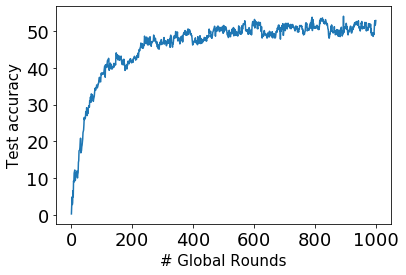

In [18]:
import matplotlib
step=1000
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18) 
#plt.plot(range(len(Cluster0_minor1)), Cluster0_minor1,label="users=2,5,5,6,7")
plt.plot(range(len(acc_test_arr[0:step])), acc_test_arr[0:step],label="without sparsification")
plt.ylabel('Test accuracy')
plt.xlabel('# Global Rounds')
#plt.legend()
#plt.figure(figsize=(6,5), dpi=400)
plt.show()

In [ ]:
print(max(acc_test_arr[0:1000]))

In [ ]:
print(max(acc_test_arr))

In [19]:
print(acc_test_arr[0:step])

[0.311750590801239, 2.7338130474090576, 4.916067123413086, 2.853717088699341, 3.3812949657440186, 6.6187052726745605, 4.940047740936279, 9.2805757522583, 8.920863151550293, 11.390887260437012, 11.870503425598145, 12.230216026306152, 9.328536987304688, 9.448441505432129, 10.74340534210205, 11.46282958984375, 11.007194519042969, 11.127098083496094, 11.966426849365234, 10.62350082397461, 10.071942329406738, 11.127098083496094, 11.510791778564453, 14.316546440124512, 14.77218246459961, 17.434053421020508, 17.553956985473633, 17.649879455566406, 18.393285751342773, 19.56834602355957, 20.863309860229492, 16.88249397277832, 17.146282196044922, 17.482013702392578, 18.53717041015625, 18.96882438659668, 19.97601890563965, 20.64748191833496, 22.374101638793945, 22.70983123779297, 23.093524932861328, 24.484413146972656, 26.474821090698242, 25.87529945373535, 26.49880027770996, 26.25899314880371, 26.42685890197754, 27.88968849182129, 28.10551643371582, 27.45803451538086, 29.136690139770508, 27.8657

In [ ]:
#torch.save(net_glob.state_dict(),"model_cnn.pt")
#for k in w_glob.keys():
#print(w_glob['conv1.weight'].to(torch.device("cuda"))-w_glob['conv1.weight'].to(torch.device("cuda")))

In [ ]:
print(loss_train)